# Vision Transformer and Masked Autoencoder

In this assignment, you will be implementing [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) and [Masked Autoencoder (MAE)](https://arxiv.org/abs/2111.06377).

In [1]:
import torch
torch.__version__

'2.5.1+cu121'

## Setup

While we recommend working on Colab with GPU enabled, for practical reasons (namely limited Colab GPU availability), our advice is to first complete this assignment in a CPU environment with small model sizes, then re-run the notebook in GPU mode with "full" model sizes".

To help you with this, in all Colab cells where you train ML models, we have provided two model settings: "ModelSize.FULL" and "ModelSize.TINY". We recommend first running "ModelSize.TINY" in a CPU runtime, and get your notebook to first successfully run end-to-end in a CPU environment. Note that, due to the smaller model sizes, it's unlikely you will hit the accuracy checks.

Once you're convinced that your implementations are correct, then switch the model train mode to use larger model sizes (eg `MODEL_SIZE = ModelSize.FULL`), switch to the GPU environment, and run the entire notebook (eg "Runtime->Run All" or "Runtime->Run cell and below").

Tip: to further reduce time, feel free to reduce number of train epochs as well: for initial checks, 5 epochs is probably good enough. Just remember to set epochs back to the full value for your final submission!

**Important**: to receive full credit on this homework (eg pass all autograder tests), you will need to submit a submission using the "ModelSize.FULL" model settings.

Note that this notebook is designed to work both in a CPU and GPU runtime.

To switch to a GPU runtime, click the dropdown menu right of the "Connect" button on the upper-right corner of the Colab UI, choose "Change runtime type", and choose "T4 GPU". This will connect you to an instance with an Nvidia GPU.

Here is a guide that shows how to change the Colab notebook runtime to the T4 GPU: [link](https://www.geeksforgeeks.org/how-to-use-gpu-in-google-colab/)

The dependencies will be installed once the notebooks are excuted.

You should make a copy of this notebook to your Google Drive otherwise the outputs will not be saved.
Once the folder is copied, you can start working by clicking a Jupyter Notebook and openning it in Colab.

In [2]:
from enum import Enum

class ModelSize(str, Enum):
    # full: use the full-sized model architectures.
    #   Recommended to use this only for GPU runtimes.
    FULL = "full"
    # tiny: use tiny model architectures.
    #   Recommended for intial development in CPU runtimes.
    TINY = "tiny"


In [3]:
# IMPORTANT: this global var controls the model size to use for this notebook.
# Advice: for initial development, set this to ModelSize.TINY and use a CPU runtime.
#   Once you're able to run this notebook end-to-end on a CPU and things seem to work
#   (but with lower accuracy due to weaker model), try switching to a GPU runtime,
#   then switch to ModelSize.FULL.
MODEL_SIZE = ModelSize.FULL

In [4]:
!nvidia-smi # Confirm GPU is enabled (only if you intend to use a GPU)

Tue Dec 10 02:15:27 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
!pip -q install einops

In [6]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn
seaborn.set()

from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import einops
import pickle
import os

torch_device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')
# IMPORTANT: change to your own root folder path! This dir should contain the contents of:
# https://github.com/datac182fa24/datac182_hw4_student
root_folder = "/content/drive/MyDrive/data182/hw4/"
os.chdir(root_folder)
# validate that we're in the right directory (ls should show files like: autograder_student.pt, data182-hw04.ipynb, etc )
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data182/hw4
autograder.pt	       content		   README.md	 test_reference.pt
autograder_student.pt  data182-hw04.ipynb  saved_models


**Note**: change ```root_folder``` to the folder of this notebook in your google drive

In [8]:
#@title Load Testing Data
os.makedirs("./content", exist_ok=True)
test_data = torch.load('./test_reference.pt', weights_only=True)
auto_grader_data = torch.load('./autograder_student.pt', weights_only=True)
auto_grader_data['output'] = {}

In [9]:
#@title Utilities for Testing
def save_auto_grader_data():
    torch.save(
        {'output': auto_grader_data['output']},
        'autograder.pt'
    )

def rel_error(x, y):
    return torch.max(
        torch.abs(x - y)
        / (torch.maximum(torch.tensor(1e-8), torch.abs(x) + torch.abs(y)))
    ).item()

def check_error(name, x, y, tol=1e-3):
    error = rel_error(x, y)
    if error > tol:
        print(f'The relative error for {name} is {error}, should be smaller than {tol}')
    else:
        print(f'The relative error for {name} is {error}')

def check_acc(acc, threshold):
    if acc < threshold:
        print(f'The accuracy {acc} should >= threshold accuracy {threshold}')
    else:
        print(f'The accuracy {acc} is better than threshold accuracy {threshold}')

## Vision Transformer
The first part of this notebook is implementing Vision Transformer (ViT) and training it on CIFAR dataset.

### Image patchify and unpatchify

In ViT, an image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. The architecture can be seen in the following figure.
![vit](https://github.com/google-research/vision_transformer/blob/main/vit_figure.png?raw=true)

To get started with implementing ViT, you need to implement splitting image batch into fixed-size patches batch in ```patchify``` and combining patches batch into the original image batch in ```unpatchify```.

We strongly recommend using [einops](https://github.com/arogozhnikov/einops) for flexible tensor operations, you can check out its [tutorial](https://einops.rocks/1-einops-basics/).

In [10]:
from einops import rearrange, repeat

def patchify(images, patch_size=4):
    """Splitting images into patches.
    Args:
        images: Input tensor with size (batch, channels, height, width)
            We can assume that image is square where height == width.
    Returns:
        A batch of image patches with size (
          batch, (height / patch_size) * (width / patch_size),
        channels * patch_size * patch_size)
    """
    batch, channels, height, width = images.shape
    assert height == width, f"Image height {height} should be equal to width {width}"
    assert height % patch_size == 0, f"Image height {height} must be divisible by patch size {patch_size}"
    assert width % patch_size == 0, f"Image width {width} must be divisible by patch size {patch_size}"
    # BEGIN YOUR CODE

    # Hint: can be implemented in 1 line, use einops rearrange (https://einops.rocks/api/rearrange/)
    # patches = rearrange(images, 'b c h w -> b (b1 b2) (c b3)', b1=height//patch_size, b2=width//patch_size, b3=channels * (patch_size ** 2))
    patches = rearrange(images, 'b c (h_p ps) (h_w ps1)  -> b (h_p h_w) (c ps ps1)', ps=patch_size, ps1=patch_size)

    # END YOUR CODE
    assert patches.shape == (batch, (height // patch_size) * (width // patch_size),
                             channels * patch_size * patch_size)

    return patches

def unpatchify(patches, patch_size=4):
    """Combining patches into images.
    Args:
        patches: Input tensor with size (
        batch, (height / patch_size) * (width / patch_size),
        channels * patch_size * patch_size)
    Returns:
        A batch of images with size (batch, channels, height, width)
    """
    # BEGIN YOUR CODE
    batch, num_patches, patch_flatten = patches.shape
    height = int((num_patches * (patch_size ** 2)) ** 0.5)
    width = int((num_patches * (patch_size ** 2)) ** 0.5)
    channels = patch_flatten * (patch_size ** 2)
    # Hint: can be implemented in 1 line, use einops rearrange (https://einops.rocks/api/rearrange/)
    images = rearrange(patches,
                       'b (h_p w_p) (c ps ps2) -> b c (h_p ps) (w_p ps2)',
                       h_p=height//patch_size,
                       w_p=width//patch_size,
                       ps=patch_size,
                       ps2 = patch_size)
    # END YOUR CODE
    return images

In [11]:
#@title Test your implementation
x = test_data['input']['patchify']
y = test_data['output']['patchify']
check_error('patchify', patchify(x), y)

x = auto_grader_data['input']['patchify']
auto_grader_data['output']['patchify'] = patchify(x)
save_auto_grader_data()


x = test_data['input']['unpatchify']
y = test_data['output']['unpatchify']
check_error('unpatchify', unpatchify(x), y)

x = auto_grader_data['input']['unpatchify']
auto_grader_data['output']['unpatchify'] = unpatchify(x)

save_auto_grader_data()

The relative error for patchify is 0.0
The relative error for unpatchify is 0.0


### ViT model

You need to use the given Transformer encoder ```Transformer``` to implement ViT in ```ViT``` and ```ClassificationViT```.

Our implementation differs from the original in that we use Global Attention Pooling instead of a dedicated classifier token. What it does is applying cross attention on the CLS token and the encoder output.

In [12]:
class Transformer(nn.Module):
    """Transformer Encoder
    Args:
        embedding_dim: dimension of embedding
        n_heads: number of attention heads
        n_layers: number of attention layers
        feedforward_dim: hidden dimension of MLP layer
    Returns:
        Transformer embedding of input
    """
    def __init__(self, embedding_dim=256, n_heads=4, n_layers=4, feedforward_dim=1024):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.feedforward_dim = feedforward_dim
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=embedding_dim,
                nhead=self.n_heads,
                dim_feedforward=self.feedforward_dim,
                activation=F.gelu,
                batch_first=True,
                dropout=0.0,
            ),
            num_layers=n_layers,
        )

    def forward(self, x):
        return self.transformer(x)

class ClassificationViT(nn.Module):
    """Vision transformer for classfication
    Args:
        n_classes: number of classes
        embedding_dim: dimension of embedding
        patch_size: side length of a square-shaped image patch
        num_patches: number of image patches per height/width
    Returns:
        Logits of classfication
    """
    def __init__(self, n_classes, embedding_dim=256, patch_size=4, num_patches=8, num_channels=3, n_layers=4, feedforward_dim=1024):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.embedding_dim = embedding_dim
        self.num_channels = num_channels
        self.n_layers = n_layers
        self.feedforward_dim = feedforward_dim
        self.n_classes = n_classes
        self.n_tokens = num_patches ** 2

        self.transformer = Transformer(embedding_dim, n_layers=n_layers, feedforward_dim=feedforward_dim)
        # We use random position encoding.
        # You are welcome to try other methods, such as sinusoidal encoding.
        self.position_encoding = nn.Parameter(
            torch.randn(1, self.n_tokens, embedding_dim) * 0.02
        )
        self.patch_projection = nn.Linear((patch_size ** 2) * num_channels, embedding_dim)

        # Global Attention Pooling for classification
        self.cls_query = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.cross_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=self.transformer.n_heads,
                                                     batch_first=True)

        # A Layernorm and a Linear layer are applied on ViT encoder embeddings
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, n_classes)
            )

    def forward(self, images):

        """
        (1) Splitting images into fixed-size patches, dividing both height and width by patch size;
        (2) Linearly embed each image patch, append CLS token;
        (3) Add position embeddings;
        (4) Feed the resulting sequence of vectors to Transformer encoder.
        (5) Perform Global Attention Pooling.
        (6) Apply output head to the embeddings to obtain the logits

        Args:
          images: (batch_size, channels, height, width)
        """

        # BEGIN YOUR CODE

        # (1) Split images into patches using patchify, can be implemented in 1 line
        patches = patchify(images, patch_size=self.patch_size)

        # (2) Linearly embed each patch, can be implemented in 1 line
        patches = self.patch_projection(patches)

        # (3) Add position embeddings to the embedded patch in step (2), can be implemented in 1 line
        patches += self.position_encoding

        # (4) Feed the resulting sequence of vectors to Transformer encoder, can be implemented in 1 line
        # Shape: (batch_size, n_patches, embedding_dim)
        transformer_patches = self.transformer(patches)

        # (5) Apply Global Attention Pooling, which applies self.cross_attention


        # on cls_query and encoder output from (4)
        # Can be implemented in < 5 lines

        batch_size = images.shape[0]
        # self.cls_query is (1, 1, embeddings_dim)
        # cls_query is (batch_size, 1, embeddings_dim)
        cls_query = self.cls_query.repeat(batch_size, 1, 1)
        # print(transformer_patches.shape)
        # torch.Size([3, 64, 256])
        gap_patches, _ = self.cross_attention(cls_query,
                                             transformer_patches,
                                             transformer_patches)
        # print(cls_output.shape)
        # torch.Size([3, 1, 256])
        gap_patches = gap_patches.squeeze(1)

        # print(cls_output.shape)
        # torch.Size([3, 256])

        # (6) Apply output head to the output to obtain the logits, can be implemented in 1 line
        logits = self.output_head(gap_patches)
        # print(logits.shape)
        # torch.Size([3, 10])
        return logits
        # END YOUR CODE

In [13]:
#@title Test your implementation
model = ClassificationViT(10)
model.load_state_dict(test_data['weights']['ClassificationViT'])
x = test_data['input']['ClassificationViT.forward']
y = model.forward(x)
check_error('ClassificationViT.forward', y, test_data['output']['ClassificationViT.forward'])

model.load_state_dict(auto_grader_data['weights']['ClassificationViT'])
x = auto_grader_data['input']['ClassificationViT.forward']
y = model.forward(x)
auto_grader_data['output']['ClassificationViT.forward'] = y
save_auto_grader_data()

The relative error for ClassificationViT.forward is 0.0


### Data Loader and Preprocess

We use ```torchvision``` to download and prepare images and labels.

In [14]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='/content/data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='/content/data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### Supervised Training ViT [train]

We have obtained up to 73.5% validation accuracy. You are required to reach at least 65% validation accuracy.

In [15]:
# Initialize model (ClassificationViT)
# GPU(full): 6 mins (~30 secs per epoch)
# CPU(full): 220 mins (~22 mins per epoch))
# CPU(tiny): 10 mins (~1 min per epoch)
print(f"Creating ClassificationViT with MODEL_SIZE={MODEL_SIZE}")
if MODEL_SIZE == ModelSize.FULL:
    model = ClassificationViT(10)
else:
    # TINY
    model = ClassificationViT(10, embedding_dim=4, n_layers=1, feedforward_dim=4)

# Move model to target device (eg GPU if available)
model.to(torch_device)
# Create optimizer for the model

# You may want to tune these hyperparameters to get better performance.
# Tip: you should be able to pass the autograder tests with these given
#   hyperparameter values on the "full" model size, assuming your model
#   implementations are correct.
optimizer = optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 10
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

savedir_path = './saved_models'
os.makedirs(savedir_path,exist_ok=True)

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    model.train()
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
            logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())

    mean_val_acc = np.mean(val_acc)
    all_val_acc.append(mean_val_acc)

    # Save best model
    if mean_val_acc > best_val_acc:
        best_val_acc = mean_val_acc
        torch.save(model.state_dict(), f'{savedir_path}/vit.pth')

    epoch_iterator.set_postfix(val_acc=mean_val_acc, best_val_acc=best_val_acc)

Creating ClassificationViT with MODEL_SIZE=full


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

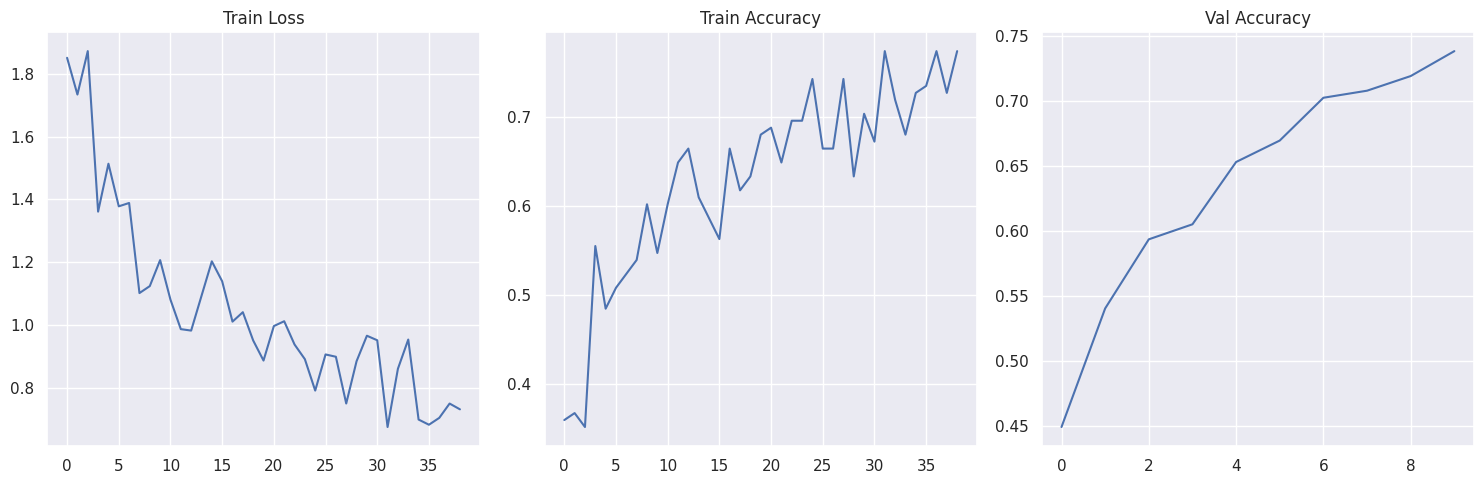

In [16]:
# Plotting
fig, axd = plt.subplot_mosaic([['loss', 'train_acc', 'val_acc']], figsize=(15, 5))

axd['loss'].plot(losses)
axd['loss'].set_title('Train Loss')

axd['train_acc'].plot(train_acc)
axd['train_acc'].set_title('Train Accuracy')

axd['val_acc'].plot(all_val_acc)
axd['val_acc'].set_title('Val Accuracy')

plt.tight_layout()
plt.show()

In [17]:
#@title Test your implementation, your accuracy should be greater than 65%
auto_grader_data['output']['vit_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.65)

The accuracy 0.7384295886075949 is better than threshold accuracy 0.65


1/0

## Masked AutoEncoder

The second part of this notebook is implementing [Masked Autoencoder (MAE)](https://en.wikipedia.org/wiki/Masked_autoencoder).
The idea of MAE is masking random patches of the input image and reconstruct the missing pixels. This whole achitecture can be seen in the following figure.
![mae](https://user-images.githubusercontent.com/11435359/146857310-f258c86c-fde6-48e8-9cee-badd2b21bd2c.png)

You will train MAE without labels on CIFAR, aka, self-supervised learning.
Then you will use the self-supervised pretrained model for linear classification and finetuning experiments.

In [18]:
def index_sequence(x, ids):
    """Index tensor (x) with indices given by ids
    Args:
        x: input sequence tensor, can be 2D (batch x length) or 3D (batch x length x feature)
        ids: 2D indices (batch x length) for re-indexing the sequence tensor
    Returns:
        result: a tensor with the same shape as x, but permuted on the "length" dimension according to ids.
    """
    batch, length = ids.shape

    assert len(x.shape) in [2, 3], f'Input tensor x should have 2 or 3 dimensions, but has shape {x.shape}'
    if len(x.shape) == 3:
        ids = ids.unsqueeze(-1).expand(-1, -1, x.shape[-1])
    result = torch.take_along_dim(x, ids, dim=1)
    assert result.shape == x.shape
    return result

def random_masking(x, keep_length, ids_shuffle):
    """Apply random masking on input tensor
    Args:
        x:  (batch, length, feature) input patches
        keep_length: int, length of unmasked patches
        ids_shuffle: (batch, length) random indices for shuffling the input sequence
    Returns:
        kept: (batch, keep_length, feature) un-masked part of x
        mask: (batch, length) a 2D (batch x length) mask tensor of 0s and 1s indicated which
            part of x is masked out. The value 0 indicates not masked and 1
            indicates masked.
        ids_restore: (batch, length) indices to restore x. If we take the kept part and masked
            part of x, concatentate them together and index it with ids_restore,
            we should get x back.

    Hint:
        ids_shuffle contains the indices used to shuffle the sequence (patches).
        You should use the provided index_sequence function to re-index the
        sequence, and keep the first keep_length number of patches.
    """
    # BEGIN YOUR CODE

    # (1) Shuffle the sequence using index_sequence
    x_shuffled = index_sequence(x, ids_shuffle)
    # (2) Keep the first keep_length patches
    kept = x_shuffled[:, :keep_length, :]
    # (3) Create ids_restore. For reference see the argsort permutation trick
    #  https://arogozhnikov.github.io/2015/09/29/NumpyTipsAndTricks1.html
    ids_restore = torch.argsort(ids_shuffle, axis=1)
    # (4) Create the mask, can be implemented in <5 lines
    mask = torch.ones(ids_shuffle.shape, device=x.device)
    mask[:, :keep_length] = 0
    mask = index_sequence(mask, ids_restore)
    return kept, mask, ids_restore

    # END YOUR CODE

def restore_masked(kept_x, masked_x, ids_restore):
    """Restore masked patches
    Args:
        kept_x: unmasked patches, (batch x keep_length x feature)
        masked_x: masked patches, (batch x mask_length x feature)
        ids_restore: indices to restore x, (batch x length)
    Returns:
        restored: restored patches, (batch x length x feature)
    """
    # BEGIN YOUR CODE

    # (1) Concatenate kept and masked patches
    concat_x = torch.cat((kept_x, masked_x), dim=1)
    # (2) Restore the original order
    restored = index_sequence(concat_x, ids_restore)
    return restored
    # END YOUR CODE

### Random Masking and Restore

To get started with MAE, you need to implement ```random_masking``` to mask random patches from the input image and ```restore_masked``` to combine reconstructed masked part and unmasked part to restore the image.

In [19]:
#@title Test your implementation
x, ids_shuffle = test_data['input']['random_masking']
kept, mask, ids_restore = random_masking(x, 4, ids_shuffle)
kept_t, mask_t, ids_restore_t = test_data['output']['random_masking']
check_error('random_masking: kept', kept, kept_t)
check_error('random_masking: mask', mask, mask_t)
check_error('random_masking: ids_restore', ids_restore, ids_restore_t)

x, ids_shuffle = auto_grader_data['input']['random_masking']
kept, mask, ids_restore = random_masking(x, 4, ids_shuffle)
auto_grader_data['output']['random_masking'] = (kept, mask, ids_restore)
save_auto_grader_data()

kept_x, masked_x, ids_restore = test_data['input']['restore_masked']
restored = restore_masked(kept_x, masked_x, ids_restore)
check_error('restore_masked', restored, test_data['output']['restore_masked'])

kept_x, masked_x, ids_restore = auto_grader_data['input']['restore_masked']
restored = restore_masked(kept_x, masked_x, ids_restore)
auto_grader_data['output']['restore_masked'] = restored
save_auto_grader_data()

The relative error for random_masking: kept is 0.0
The relative error for random_masking: mask is 0.0
The relative error for random_masking: ids_restore is 0.0
The relative error for restore_masked is 0.0


## Implement MAE



In [20]:
from einops import rearrange, repeat

class MaskedAutoEncoder(nn.Module):
    """MAE Encoder
    Args:
        encoder: ViT encoder
        decoder: ViT decoder
        encoder_embedding_dim: embedding size of encoder
        decoder_embedding_dim: embedding size of decoder
        patch_size: side length of a square-shaped image patch
        num_patches: number of patches per height/width
        mask_ratio: percentage of masked patches
    """
    def __init__(self, encoder, decoder, encoder_embedding_dim=256,
                 decoder_embedding_dim=128, patch_size=4, num_patches=8,
                 mask_ratio=0.75, channels=3):
        super().__init__()
        self.encoder_embedding_dim = encoder_embedding_dim
        self.decoder_embedding_dim = decoder_embedding_dim
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        self.channels = channels

        self.masked_length = int(num_patches * num_patches * mask_ratio)
        self.keep_length = num_patches * num_patches - self.masked_length

        self.encoder = encoder
        self.decoder = decoder

        self.encoder_input_projection = nn.Linear(patch_size * patch_size * channels, encoder_embedding_dim)
        self.decoder_input_projection = nn.Linear(encoder_embedding_dim, decoder_embedding_dim)
        self.decoder_output_projection = nn.Linear(decoder_embedding_dim, patch_size * patch_size * channels)
        self.encoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, encoder_embedding_dim) * 0.02)
        self.decoder_position_encoding = nn.Parameter(torch.randn(1, num_patches * num_patches, decoder_embedding_dim) * 0.02)
        self.masked_tokens = nn.Parameter(torch.randn(1, 1, decoder_embedding_dim) * 0.02)

    def forward_encoder(self, images, ids_shuffle=None):
        """Encode input images
        You should implement the following steps
        (1) patchify images into patches
        (2) linear projection
        (3) add position encoding
        (4) apply random masking, and pass it to ViT encoder
        Args:
            images: (batch x height x width x channel)
            ids_shuffle: (batch x num_patches) tensor for shuffling the patches.
                         If None, then a random shuffle is used.
        Returns:
            encoder_embeddings: output patches, (batch x keep_length x feature)
            mask: a 2D (batch x num_patches) mask tensor of 0s and 1s indicated which
                  part of x is masked out. The value 0 indicates not masked and 1
                  indicates masked.
            ids_restore: (batch x num_patches) tensor, indices to restore x.
        """
        batch_size, channels, height, width = images.shape
        assert height == width == self.num_patches * self.patch_size

        # Generate random shuffling indices
        if ids_shuffle is None:
            ids_shuffle = torch.argsort(
                torch.rand(
                    (batch_size, self.num_patches * self.num_patches),
                    device=images.device
                ),
                dim=1
            )
        # BEGIN YOUR CODE
        # (1) Patchify images
        patches = patchify(images, patch_size=self.patch_size)
        # (2) Linear projection
        patches = self.encoder_input_projection(patches)
        # (3) Add position encoding to linear projections
        patches = patches + self.encoder_position_encoding
        # (4) Apply random masking and pass to ViT encoder
        kept, mask, ids_restore = random_masking(patches, self.keep_length, ids_shuffle)
        # (5) Pass through the encoder
        encoder_embeddings = self.encoder(kept)

        return encoder_embeddings, mask, ids_restore
        # END YOUR CODE

    def forward_decoder(self, encoder_embeddings, ids_restore):
        """Decode encoder embeddings
        You should implement the following steps
        (1) linear projection of encoder embeddings
        (2) restore array of patches from masked_patches and encoder predictions
        (3) add position encoding
        (4) pass it to ViT decoder, then apply the output projection to predict image patches

        Returns:
            predicted_patches: (batch, num_patches, patch_size * patch_size * channels)
                               All predicted patches, including masked and unmasked ones.
        """
        # BEGIN YOUR CODE
        batch_size = encoder_embeddings.shape[0]

        # (1) Linear projection of encoder embeddings
        encoder_predictions = self.decoder_input_projection(encoder_embeddings)
        # (2) Restore sequence from masked_patches and encoder predictions. Can be implemented in <5 lines
        masked_x = self.masked_tokens.expand(batch_size, self.masked_length, -1)
        restored_mask = restore_masked(encoder_predictions, masked_x, ids_restore)

        # (3) Add position encoding to result
        restored_mask =  restored_mask + self.decoder_position_encoding
        # (4) Pass through ViT decoder and apply output projection
        restored_mask = self.decoder(restored_mask)
        predicted_patches = self.decoder_output_projection(restored_mask)
        return predicted_patches
        # END YOUR CODE

    def forward(self, images):
        encoder_output, mask, ids_restore = self.forward_encoder(images)
        decoder_output = self.forward_decoder(encoder_output, ids_restore)
        return decoder_output, mask

    def forward_encoder_representation(self, images):
        """Encode images without applying random masking to get representation
        of input images. It is just forward_encoder without masking.

        Returns:
            encoder_embeddings: output patches, (batch x keep_length x feature)
        """
        # BEGIN YOUR CODE

        # (1) Patchify images
        patch = patchify(images, patch_size=self.patch_size)
        # (2) Apply linear input projection and add position encoding
        patch = self.encoder_input_projection(patch)
        patch = patch + self.encoder_position_encoding
        # (3) Pass through the encoder
        encoder_embeddings = self.encoder(patch)
        return encoder_embeddings
        # END YOUR CODE

In [21]:
#@title Test your implementation
model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)

model.load_state_dict(test_data['weights']['MaskedAutoEncoder'])
images, ids_shuffle = test_data['input']['MaskedAutoEncoder.forward_encoder']
encoder_embeddings_t, mask_t, ids_restore_t = test_data['output']['MaskedAutoEncoder.forward_encoder']
encoder_embeddings, mask, ids_restore = model.forward_encoder(
    images, ids_shuffle
)

check_error(
    'MaskedAutoEncoder.forward_encoder: encoder_embeddings',
    encoder_embeddings, encoder_embeddings_t
)
check_error(
    'MaskedAutoEncoder.forward_encoder: mask',
    mask, mask_t
)
check_error(
    'MaskedAutoEncoder.forward_encoder: ids_restore',
    ids_restore, ids_restore_t
)

encoder_embeddings, ids_restore = test_data['input']['MaskedAutoEncoder.forward_decoder']
decoder_output_t = test_data['output']['MaskedAutoEncoder.forward_decoder']
decoder_output = model.forward_decoder(encoder_embeddings, ids_restore)
check_error(
    'MaskedAutoEncoder.forward_decoder',
    decoder_output,
    decoder_output_t
)

images = test_data['input']['MaskedAutoEncoder.forward_encoder_representation']
encoder_representations_t = test_data['output']['MaskedAutoEncoder.forward_encoder_representation']
encoder_representations = model.forward_encoder_representation(images)
check_error(
    'MaskedAutoEncoder.forward_encoder_representation',
    encoder_representations,
    encoder_representations_t
)

model = MaskedAutoEncoder(
    Transformer(embedding_dim=256, n_layers=4),
    Transformer(embedding_dim=128, n_layers=2),
)

model.load_state_dict(auto_grader_data['weights']['MaskedAutoEncoder'])
images, ids_shuffle = auto_grader_data['input']['MaskedAutoEncoder.forward_encoder']
auto_grader_data['output']['MaskedAutoEncoder.forward_encoder'] = model.forward_encoder(
    images, ids_shuffle
)

encoder_embeddings, ids_restore = auto_grader_data['input']['MaskedAutoEncoder.forward_decoder']
auto_grader_data['output']['MaskedAutoEncoder.forward_decoder'] = model.forward_decoder(encoder_embeddings, ids_restore)

images = auto_grader_data['input']['MaskedAutoEncoder.forward_encoder_representation']
auto_grader_data['output']['MaskedAutoEncoder.forward_encoder_representation'] = model.forward_encoder_representation(images)
save_auto_grader_data()

The relative error for MaskedAutoEncoder.forward_encoder: encoder_embeddings is 0.0
The relative error for MaskedAutoEncoder.forward_encoder: mask is 0.0
The relative error for MaskedAutoEncoder.forward_encoder: ids_restore is 0.0
The relative error for MaskedAutoEncoder.forward_decoder is 0.0
The relative error for MaskedAutoEncoder.forward_encoder_representation is 0.0


### Train Masked Autoencoder [train]

In [22]:
# Initialize MAE model
# GPU(full): 10 mins (30 secs per epoch)
# CPU(full): 240 mins (12 mins per epoch)
# CPU(tiny): 20 mins (1 min per epoch)
print(f"Creating MaskedAutoEncoder with MODEL_SIZE={MODEL_SIZE}")
if MODEL_SIZE == ModelSize.FULL:
    model = MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
else:
    # TINY
    model = MaskedAutoEncoder(
        Transformer(embedding_dim=4, n_layers=1, feedforward_dim=4),
        Transformer(embedding_dim=4, n_layers=1, feedforward_dim=4),
        encoder_embedding_dim=4,
        decoder_embedding_dim=4,
    )

# Move the model to target device (eg GPU if available)
model.to(torch_device)
# Create optimizer

# You may want to tune these hyperparameters to get better performance
# Tip: with correct model implementation (and on "full" model size), you should be able
#   to pass autograder tests with these given hyperparameter values.
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=0.05)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
best_loss = float('inf')

savedir_path = './saved_models'
os.makedirs(savedir_path,exist_ok=True)

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x = x.to(torch_device)
        image_patches = patchify(x)
        predicted_patches, mask = model(x)
        loss = torch.sum(torch.mean(torch.square(image_patches - predicted_patches), dim=-1) * mask) / mask.sum()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item())
        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model.state_dict(), f'{savedir_path}/mae_pretrained.pth')

# load trained model
model.load_state_dict(torch.load(f'{savedir_path}/mae_pretrained.pth', weights_only=True))

Creating MaskedAutoEncoder with MODEL_SIZE=full


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

<All keys matched successfully>

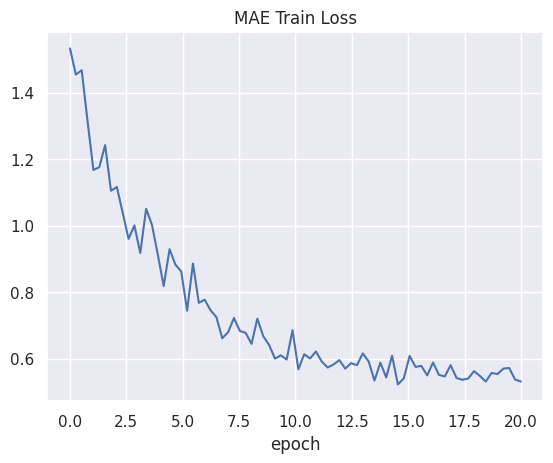

In [23]:
epochs = np.linspace(0, 1, len(losses)) * len(epoch_iterator)
plt.plot(epochs, losses)
plt.title('MAE Train Loss')
plt.xlabel('epoch')
plt.show()

### Use pretrained MAE model for classification

We train a shallow head to classify on top of the self-supervised representation learned by the MAE. It first processes the output from the MAE encoder by a multiheaded attention pooling, then layernorm, then linear.

In [24]:
class ClassificationMAE(nn.Module):
    """MAP-layernorm-linear classifier trained on the
       self-supervised representations learned by MAE.
    Args:
        n_classes: number of classes
        mae: mae model
        embedding_dim: embedding dimension of mae output
        detach: if True, only the classification head is updated.
    """
    def __init__(self, n_classes, mae, embedding_dim=256, detach=False):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mae = mae

        # Multiheaded Attention Pooling for classification
        self.cls_query = nn.Parameter(torch.randn(1, 1, embedding_dim))
        self.cross_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                     num_heads=4,
                                                     batch_first=True)

        # A Layernorm and a Linear layer are applied on ViT encoder embeddings
        self.output_head = nn.Sequential(
            nn.LayerNorm(embedding_dim), nn.Linear(embedding_dim, n_classes)
        )

        """
        When self.detach=True, use linear classification, when self.detach=False,
        use full finetuning.
        """
        self.detach = detach

    def forward(self, images):
        # BEGIN YOUR CODE

        # (1) Get encoder representations using MAE
        decoder_output = self.mae.forward_encoder_representation(images)
        # (2) If detach, detach the output (https://pytorch.org/docs/stable/generated/torch.Tensor.detach.html)
        decoder_output = decoder_output.detach() if self.detach else decoder_output
        # (3) Apply Multiheaded Attention Pooling, can be implemented in <5 lines
        batch_size = images.shape[0]
        cls_query = self.cls_query.repeat(batch_size, 1, 1)
        gap_patches,_ = self.cross_attention(cls_query,
                                             decoder_output,
                                             decoder_output)
        # (4) Reshape pooled output
        gap_patches = gap_patches.squeeze(1)
        # (5) Apply output head to get logits
        logits = self.output_head(gap_patches)
        return logits
        # END YOUR CODE

In [25]:
#@title Test your implementation
model = ClassificationMAE(
    10,
    MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
)

model.load_state_dict(test_data['weights']['ClassificationMAE'])

check_error(
    'ClassificationMAE.forward',
    model(test_data['input']['ClassificationMAE.forward']),
    test_data['output']['ClassificationMAE.forward']
)

model = ClassificationMAE(
    10,
    MaskedAutoEncoder(
        Transformer(embedding_dim=256, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
)

model.load_state_dict(auto_grader_data['weights']['ClassificationMAE'])
auto_grader_data['output']['ClassificationMAE.forward'] = model(
    auto_grader_data['input']['ClassificationMAE.forward']
)
save_auto_grader_data()

The relative error for ClassificationMAE.forward is 0.0


### Linear Classification [train]

A linear classifier is trained on self-supervised representations learned by MAE.

In [26]:
# Initilize classification model; set detach=True to only update the linear classifier.
# GPU(full): 10 mins (30 secs per epoch)
# CPU(full): >3 hours
# CPU(tiny): 13 mins (40 secs per epoch)
# IMPORTANT: `mae` must be kept in sync with the model arch used to generate "mae_pretrained.pth"
#   If you get an error like this:
#       Error(s) in loading state_dict for MaskedAutoEncoder: Missing key(s) in state_dict
#   Then this means there is a mismatch between your `mae` definition and what
#   is saved in "mae_pretrained.pth".
#   Worst case: if you don't remember the settings, you can re-run the "Train Masked Autoencoder",
#     then copy+paste the model definition from that cell to here
print(f"Creating MaskedAutoEncoder with MODEL_SIZE={MODEL_SIZE}")
if MODEL_SIZE == ModelSize.FULL:
    encoder_embedding_dim = 256
    mae = MaskedAutoEncoder(
        Transformer(embedding_dim=encoder_embedding_dim, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
else:
    # TINY
    encoder_embedding_dim = 4
    mae = MaskedAutoEncoder(
        Transformer(embedding_dim=encoder_embedding_dim, n_layers=1, feedforward_dim=4),
        Transformer(embedding_dim=4, n_layers=1, feedforward_dim=4),
        encoder_embedding_dim=encoder_embedding_dim,
        decoder_embedding_dim=4,
    )

mae.load_state_dict(torch.load(f'{savedir_path}/mae_pretrained.pth', weights_only=True))
model = ClassificationMAE(10, mae, embedding_dim=encoder_embedding_dim, detach=True)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
# Tip: with a correct implementation (and "full" model size), you should be able to pass
#   the autograder tests with these provided hyperparameter values.
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())

    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)
        torch.save(model.state_dict(), f'{savedir_path}/mae_cls_head.pth')

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

Creating MaskedAutoEncoder with MODEL_SIZE=full


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

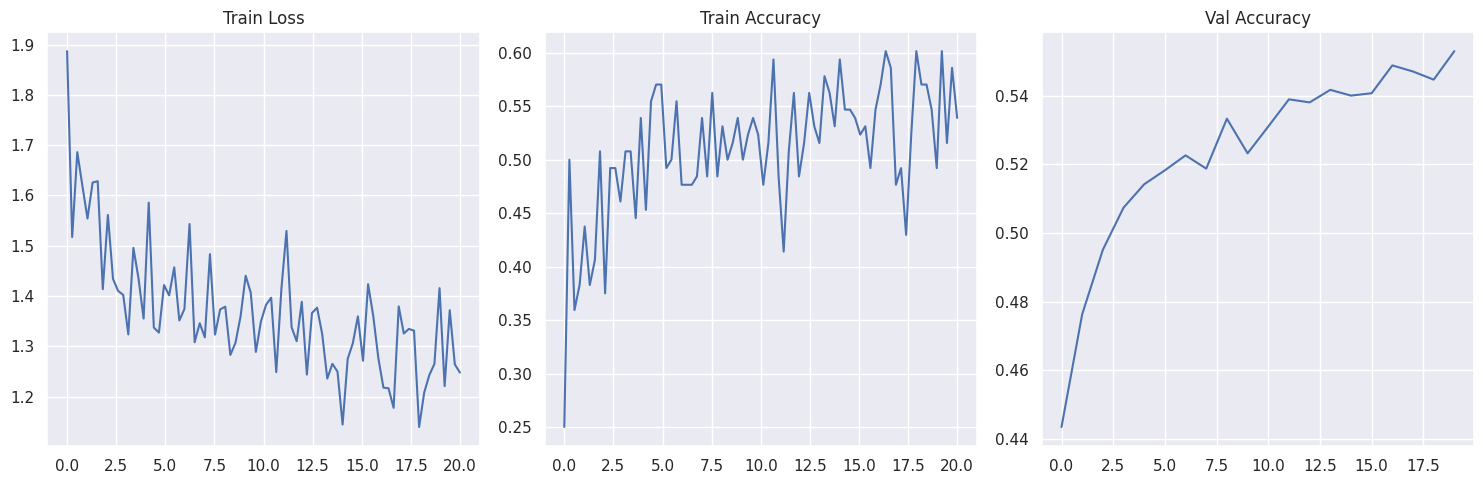

In [27]:
# Plotting
epochs = np.linspace(0, 1, len(losses)) * len(epoch_iterator)

fig, axd = plt.subplot_mosaic([['loss', 'train_acc', 'val_acc']], figsize=(15, 5))

axd['loss'].plot(epochs, losses)
axd['loss'].set_title('Train Loss')

axd['train_acc'].plot(epochs, train_acc)
axd['train_acc'].set_title('Train Accuracy')

axd['val_acc'].plot(all_val_acc)
axd['val_acc'].set_title('Val Accuracy')

plt.tight_layout()
plt.show()

In [28]:
#@title Test your implementation, your accuracy should be greater than 24%
auto_grader_data['output']['mae_linear_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.24)

The accuracy 0.553006329113924 is better than threshold accuracy 0.24


### Full Finetuning [train]

A linear classifer and the pretrained MAE model are jointly updated.

In [29]:
# Initialize classification model; set detach=False to update both the linear classifier and pretrained MAE model.
# GPU(T4): 11 mins (33 secs per epoch)
# CPU: >3 hours
# CPU(tiny): 18 mins (50 secs per epoch)

# IMPORTANT: `mae` must be kept in sync with the model arch used to generate "mae_pretrained.pth"
print(f"Creating MaskedAutoEncoder with MODEL_SIZE={MODEL_SIZE}")
if MODEL_SIZE == ModelSize.FULL:
    encoder_embedding_dim = 256
    mae = MaskedAutoEncoder(
        Transformer(embedding_dim=encoder_embedding_dim, n_layers=4),
        Transformer(embedding_dim=128, n_layers=2),
    )
else:
    # TINY
    encoder_embedding_dim = 4
    mae = MaskedAutoEncoder(
        Transformer(embedding_dim=encoder_embedding_dim, n_layers=1, feedforward_dim=4),
        Transformer(embedding_dim=4, n_layers=1, feedforward_dim=4),
        encoder_embedding_dim=encoder_embedding_dim,
        decoder_embedding_dim=4,
    )
mae.load_state_dict(torch.load(f'{savedir_path}/mae_pretrained.pth', weights_only=True))
model = ClassificationMAE(10, mae, embedding_dim=encoder_embedding_dim, detach=False)
model.to(torch_device)

# You may want to tune these hyperparameters to get better performance
optimizer = optim.AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.95), weight_decay=1e-9)

total_steps = 0
num_epochs = 20
train_logfreq = 100
losses = []
train_acc = []
all_val_acc = []
best_val_acc = 0

epoch_iterator = trange(num_epochs)
for epoch in epoch_iterator:
    # Train
    data_iterator = tqdm(trainloader)
    for x, y in data_iterator:
        total_steps += 1
        x, y = x.to(torch_device), y.to(torch_device)
        logits = model(x)
        loss = torch.mean(F.cross_entropy(logits, y))
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        data_iterator.set_postfix(loss=loss.item(), train_acc=accuracy.item())

        if total_steps % train_logfreq == 0:
            losses.append(loss.item())
            train_acc.append(accuracy.item())

    # Validation
    val_acc = []
    model.eval()
    for x, y in testloader:
        x, y = x.to(torch_device), y.to(torch_device)
        with torch.no_grad():
          logits = model(x)
        accuracy = torch.mean((torch.argmax(logits, dim=-1) == y).float())
        val_acc.append(accuracy.item())
    model.train()

    all_val_acc.append(np.mean(val_acc))

    # Save best model
    if np.mean(val_acc) > best_val_acc:
        best_val_acc = np.mean(val_acc)
        torch.save(model.state_dict(), f'{savedir_path}/mae_cls_full.pth')

    epoch_iterator.set_postfix(val_acc=np.mean(val_acc), best_val_acc=best_val_acc)

Creating MaskedAutoEncoder with MODEL_SIZE=full


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

  0%|          | 0/391 [00:00<?, ?it/s]

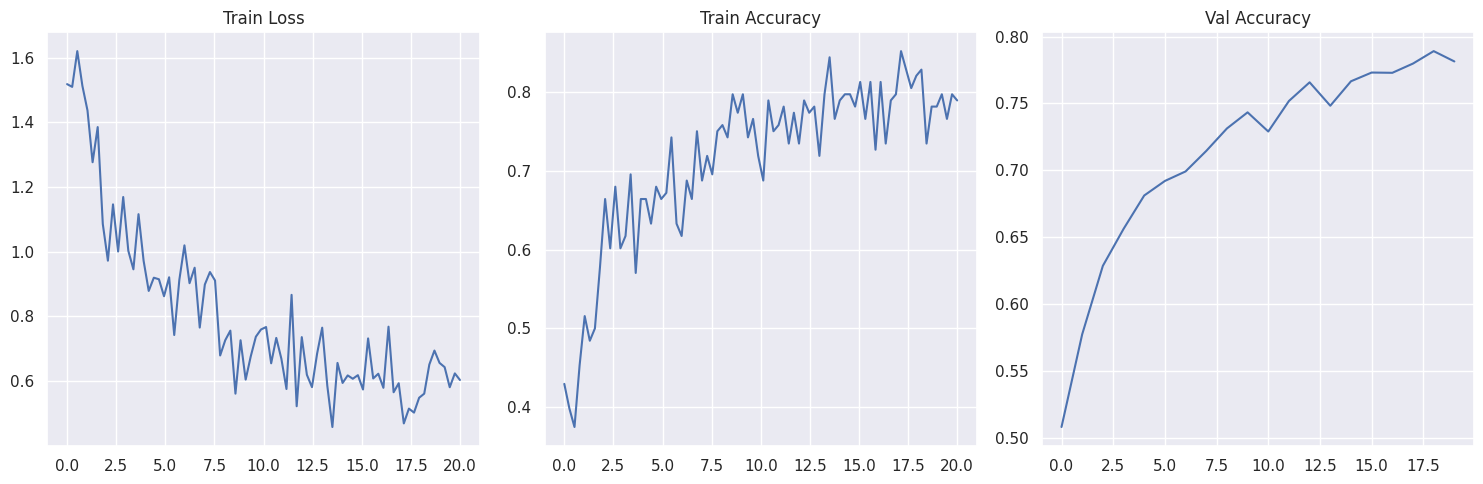

In [30]:
# Plotting
epochs = np.linspace(0, 1, len(losses)) * len(epoch_iterator)

fig, axd = plt.subplot_mosaic([['loss', 'train_acc', 'val_acc']], figsize=(15, 5))

axd['loss'].plot(epochs, losses)
axd['loss'].set_title('Train Loss')

axd['train_acc'].plot(epochs, train_acc)
axd['train_acc'].set_title('Train Accuracy')

axd['val_acc'].plot(all_val_acc)
axd['val_acc'].set_title('Val Accuracy')

plt.tight_layout()
plt.show()

In [31]:
#@title Test your implementation, your validation accuracy should be greater than 65%
auto_grader_data['output']['mae_finetune_acc'] = best_val_acc
save_auto_grader_data()
check_acc(best_val_acc, threshold=0.65)

The accuracy 0.7891613924050633 is better than threshold accuracy 0.65


## Prepare Gradescope submission

**NOTE:** The following uses the value of `root_folder` that you set in the beginning. Make sure it's correct before running these cells!

Run the following cell will automatically prepare and downloads ```hw4_submission.zip``` (to your browser's default download directory).

Upload the downloaded file to Gradescope.
The Gradescope will run an autograder on the files you submit.

It is very unlikely but still possible that your implementation might fail to pass some test cases due to randomness.
If you think your code is correct, you can simply rerun the autograder to check check whether it is really due to randomness.

In [32]:
# Sanity check: do these look correct? Notably, `root_folder` and "!pwd" should output the same thing
print("root_folder:")
print(root_folder)
print("pwd:")
!pwd
print("ls:")
!ls

root_folder:
/content/drive/MyDrive/data182/hw4/
pwd:
/content/drive/MyDrive/data182/hw4
ls:
autograder.pt	       content		   README.md	 test_reference.pt
autograder_student.pt  data182-hw04.ipynb  saved_models


In [33]:
# Save the dictionaries
save_auto_grader_data()

In [34]:
# IMPORTANT: be sure that `root_folder` is defined correctly in previous cell
# Note: It's OK if the `rm` command fails, this is normal if this is your first
#   time running this.
os.chdir(root_folder)
!pwd # make sure we are in the right dir
!ls

!rm hw4_submission.zip
!zip hw4_submission.zip -r *.ipynb autograder.pt

from google.colab import files
outpath_zip = "hw4_submission.zip"
files.download(outpath_zip)
print(f"Finished downloading {outpath_zip}! Upload this zip file to Gradescope as your submission to run the autograder. The {outpath_zip} file will be in your browser's default download directory.")


/content/drive/MyDrive/data182/hw4
autograder.pt	       content		   README.md	 test_reference.pt
autograder_student.pt  data182-hw04.ipynb  saved_models
rm: cannot remove 'hw4_submission.zip': No such file or directory
  adding: data182-hw04.ipynb (deflated 73%)
  adding: autograder.pt (deflated 16%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finished downloading hw4_submission.zip! Upload this zip file to Gradescope as your submission to run the autograder. The hw4_submission.zip file will be in your browser's default download directory.
